In [1]:
import mdtraj as md

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#from itertools import product
#from scipy import stats

## Read trajs and colvars

### Read topology and select atoms of protein

In [2]:
basedir = '/home/vault/bcpc/bcpc001h/Photoswitches/b2AR_3PDS_UW58_Z_thiol/metaD_multiple_walker_40_ns_10_bias_C10'
topol_filename = f'{basedir}/trajectory/w0.gro'
walkers_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
trajectories_filenames = [f'{basedir}/trajectory/w{i}.xtc' for i in walkers_indices]
colvar_filenames = [f'{basedir}colvar/COLVAR.{i}' for i in walkers_indices]

In [3]:
# read topology
topology = md.load(topol_filename)

# if needed, print residue indices
if False:
  for i, res in enumerate(topology.top.residues):
    if i<290:
      print((i, res.name, res, res.resSeq, res.index))

## get indices of atoms in the protein
keep_atoms = []
for atom in topology.top.atoms:
  if atom.residue.index < 291:
    keep_atoms.append(atom.index)


In [4]:
print(f'protein atoms {len(keep_atoms)}')

protein atoms 4722


### Read trajectories (only protein atoms)

In [5]:
## read trajectories
trajectories = [md.load(trj_name, top = topology.top, atom_indices=keep_atoms) for trj_name in trajectories_filenames]

In [6]:
for trj in trajectories:
  print(trj)

# define top for protein only
top_proteinonly = trajectories[0].top

<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, and unitcells>
<mdtraj.Trajectory with 2001 frames, 4722 atoms, 291 residues, a

### Read original COLVARS

In [7]:
# read COLVARs
cols = ['time', 'd1.x', 'd1.y', 'd1.z', 's_cent', 'beta_cent',
       'wall_width', 'wall_buffer', 'lwall.bias', 'lwall.force2', 'uwall.bias',
       'uwall.force2', 'wall_center', 'wall_height', 'wall_steepness', 'dxy',
       'wall_bias', 'finalbias.bias', 'finalbias.wall_bias_bias', 'meta.bias',
       'meta.rbias', 'meta.rct']

original_cvs = []
for i, colvar_name in enumerate(colvar_filenames):
  cv = pd.read_csv(colvar_name, sep=" ", names=cols, skiprows=1, comment="#")
  cv_cleaned = cv.reset_index().drop(['index'],axis=1)
  original_cvs.append(cv_cleaned)
  max_time = max(cv_cleaned['time'])
  nrows = len(cv_cleaned)
  print(f'COLVAR file {i}: maxtime= {max_time}, nrows = {nrows}')


COLVAR file 0: maxtime= 200000.0, nrows = 200005
COLVAR file 1: maxtime= 200000.0, nrows = 200005
COLVAR file 2: maxtime= 200000.0, nrows = 200005
COLVAR file 3: maxtime= 200000.0, nrows = 200005
COLVAR file 4: maxtime= 200000.0, nrows = 200005
COLVAR file 5: maxtime= 200000.0, nrows = 200005
COLVAR file 6: maxtime= 200000.0, nrows = 200005
COLVAR file 7: maxtime= 200000.0, nrows = 200005
COLVAR file 8: maxtime= 200000.0, nrows = 200005
COLVAR file 9: maxtime= 200000.0, nrows = 200005
COLVAR file 10: maxtime= 200000.0, nrows = 200005
COLVAR file 11: maxtime= 200000.0, nrows = 200005
COLVAR file 12: maxtime= 200000.0, nrows = 200005
COLVAR file 13: maxtime= 200000.0, nrows = 200005
COLVAR file 14: maxtime= 200000.0, nrows = 200005
COLVAR file 15: maxtime= 200000.0, nrows = 200005
COLVAR file 16: maxtime= 200000.0, nrows = 200005
COLVAR file 17: maxtime= 200000.0, nrows = 200005
COLVAR file 18: maxtime= 200000.0, nrows = 200005
COLVAR file 19: maxtime= 200000.0, nrows = 200005
COLVAR fil

## Calculate colvars

### recalc original colvars (distance)

In [9]:
## calculate original cvs
# c1: CENTER ATOMS=3743,1455 # center 233Trp-90Val
# d1: DISTANCE ATOMS=c1,1076 COMPONENTS # c1 70MOL C10

## check we have the right atoms
for i in [3743, 1455, 4647]:
    atom = top_proteinonly.atom(i-1)
    print((i, atom.residue, atom.name))

(3743, PHE236, 'O')
(1455, GLH95, 'HB3')
(4647, MOL291, 'N1')


In [10]:
## be careful to subtract one as atom numbers in gro/plumed start from 1 and in mdtraj start from 0

def recalculate_cv(traj):
 at1 = traj.xyz[:, 3669-1, :]
 at2 = traj.xyz[:, 1381-1, :]
 at3 = traj.xyz[:, 4681-1, :]
 com = (at1 + at2)/2
 vect = at3 - com

 # original colvar has times in ps,
 # here we have 10 frames/ns, i.e. row index * 100 is time in ps
 times = [t*100 for t in range(vect.shape[0])]

 df = pd.DataFrame(vect, columns=['d1.x','d1.y','d1.z'])
 df['time'] = times

 return df

In [11]:
recalc_cvs = [recalculate_cv(trj) for trj in trajectories]

/sc/arion/projects/H_filizm02a/eduard_neu/environments/mdtraj_p310/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/sc/arion/projects/H_filizm02a/eduard_neu/environments/mdtraj_p310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


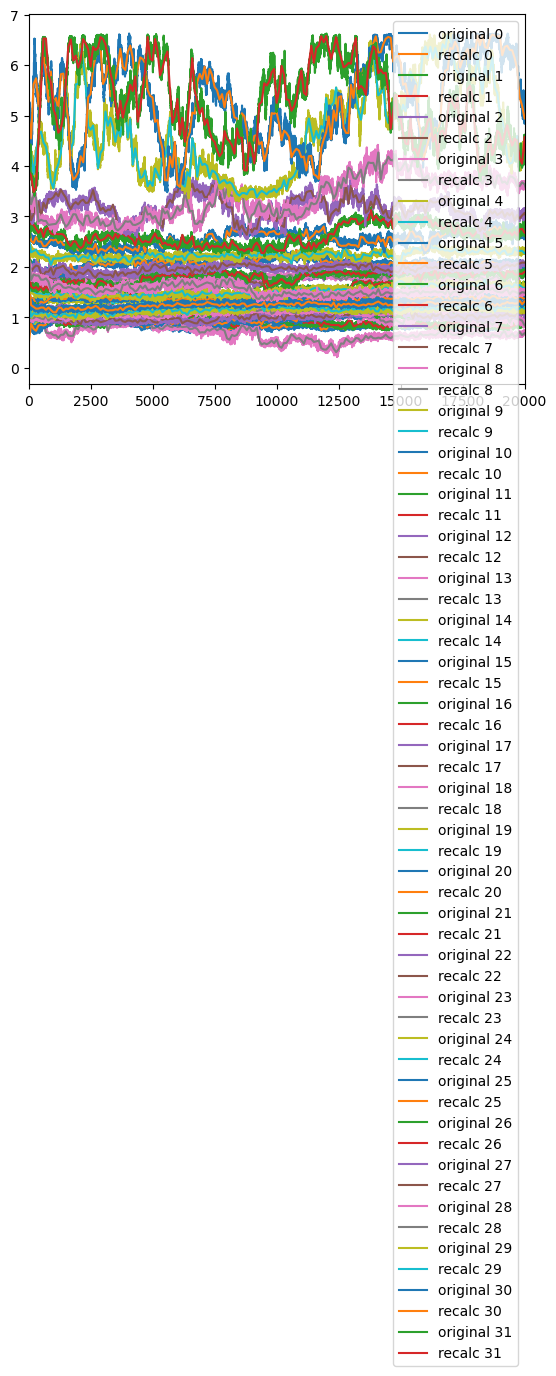

In [12]:
for i in range(len(walkers_indices)):
  plt.plot(original_cvs[i]['time'], original_cvs[i]['d1.z'],label=f'original {i}')
  plt.plot(recalc_cvs[i]['time'],recalc_cvs[i]['d1.z'],label=f'recalc {i}')
  plt.legend()
  plt.xlim(0,20000)

In [14]:
## stride original to get only the points we have in the recalculated
original_cvs_strided_withduplicates = [ocv.loc[ ( ocv['time'] % 100 == 0 )] for ocv in original_cvs]
original_cvs_strided = [ocv.drop_duplicates(['time']) for ocv in original_cvs_strided_withduplicates]



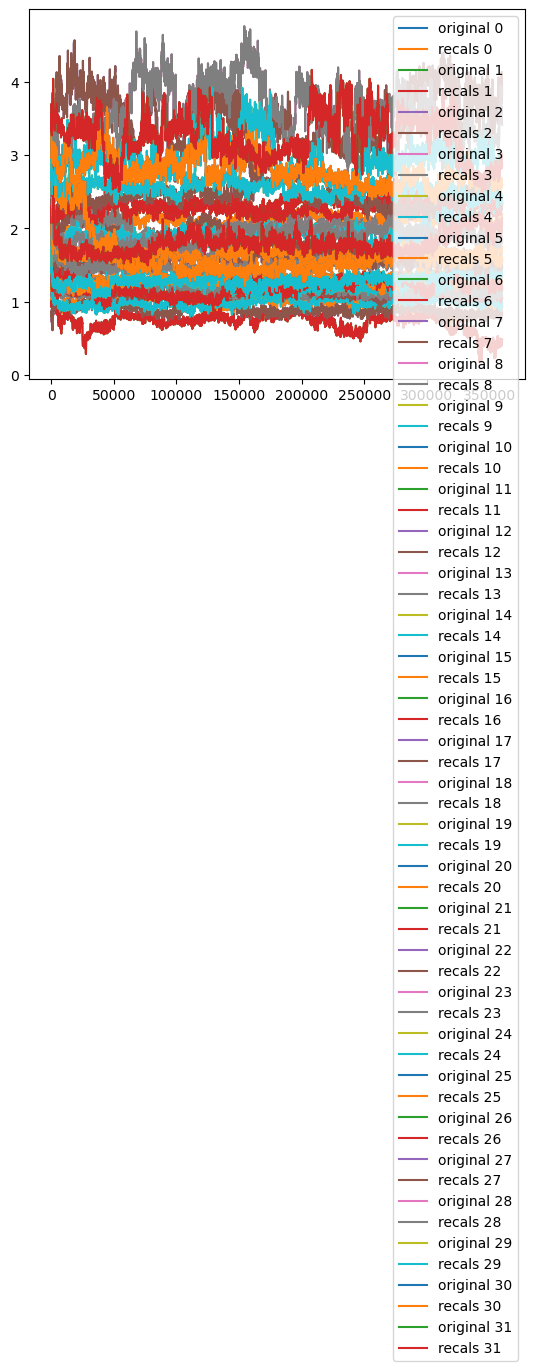

In [13]:
for i in range(len(walkers_indices)):
  plt.plot(original_cvs_strided[i]['time'], original_cvs_strided[i]['d1.z'], label=f'original {i}')
  plt.plot(recalc_cvs[i]['time'],recalc_cvs[i]['d1.z'],label=f'recals {i}')
  plt.legend()


In [15]:
original_cvs_strided[0].columns

Index(['time', 'd1.x', 'd1.y', 'd1.z', 's_cent', 'beta_cent', 'wall_width',
       'wall_buffer', 'lwall.bias', 'lwall.force2', 'uwall.bias',
       'uwall.force2', 'wall_center', 'wall_height', 'wall_steepness', 'dxy',
       'wall_bias', 'finalbias.bias', 'finalbias.wall_bias_bias', 'meta.bias',
       'meta.rbias', 'meta.rct'],
      dtype='object')

In [105]:
#rct is the the reweighting factor c(t)
#rbis the instantaneous value of the bias normalized using the c(t) reweighting factor [rbias=bias-rct].This component can be used to obtain a reweighted histogram


### Calculate new CVS coordination between ligand and protein

We calculate the minimum distances between the ligand and residues (heavy atoms) and apply the switching function with a $r_0=0.4~nm$

In [107]:
## identify residue index for the ligand
atom_in_ligand = top_proteinonly.atom(4647-1)
ligand_residue_index = atom_in_ligand.residue.index
print(ligand_residue_index)

290


In [108]:
# compute_contacts calculates the distances between residues
# manual entry for compute_contacts
# https://mdtraj.org/1.9.3/api/generated/mdtraj.compute_contacts.html

In [109]:
group1 = [ligand_residue_index]
group2 = [res.index for res in top_proteinonly.residues if not res.index==ligand_residue_index]
pairs = [[res1,res2] for res1 in group1 for res2 in group2]

def switch(distance, r0=0.4,n=10, m=20):
  rho = (distance/r0)
  return (1-rho**n)/(1-rho**m)

contacts = []
for traj in trajectories:
  ## the first element is an array with all the distances, the second is the residue pairs
  mindistances, respairs = md.compute_contacts(traj, contacts=pairs, scheme='closest-heavy')

  ## contacts = np.sum(1*mindistances<0.4,axis=1)
  contact_count = np.sum(switch(mindistances),axis=1)
  # original colvar has times in ps,
  # here we have 10 frames/ns, i.e. row index * 100 is time in ps
  times = [t*100 for t in range(contact_count.shape[0])]

  contact_count_df = pd.DataFrame(contact_count, columns=['contact_count'])
  contact_count_df['time']=times
  contacts.append(contact_count_df)


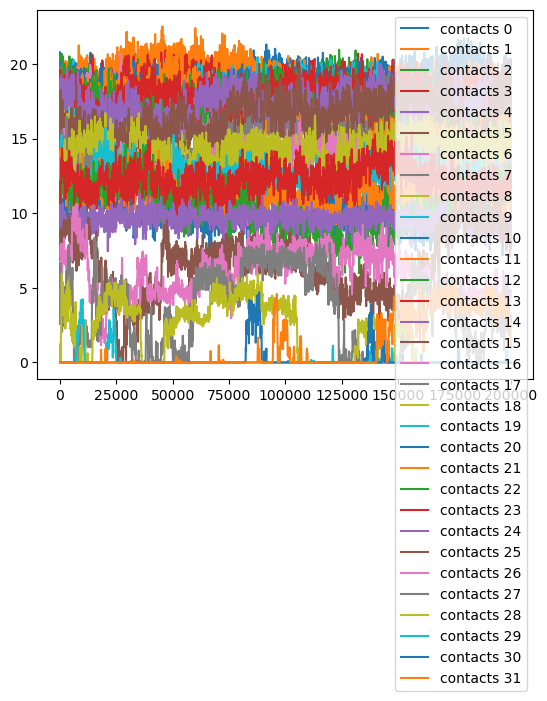

In [110]:
for i in range(len(walkers_indices)):
  plt.plot(contacts[i]['time'],contacts[i]['contact_count'],label=f'contacts {i}')
  plt.legend()

### Calculate new CV: protein-ligand + ligand-ligand 2d embedding and clustering

In [111]:
## fragment definition for ligand
fragments_long = {
    'Benzoxazinone': [('C1',  4649), ('C2',  4651), ('C3',  4656), ('C4',  4655), ('O1',  4650), ('O2',  4654), ('N1',  4647)],
    'Benyzl': [('C5',  4664), ('C26', 4662), ('C27', 4660), ('C28', 4657), ('O4',  4658)],
    'Phenyl': [('C10', 4681), ('C11', 4686), ('C12', 4688), ('C13', 4690), ('C24', 4683), ('C25', 4682)],
    'Pyrazol': [ ('C14', 4693), ('C15', 4700), ('C16', 4701), ('N5' , 4705), ('N6' , 4695), ('C22', 4694), ('C23', 4696) ],
    'Disulfide': [ ('C21', 4718), ('S1' , 4721)] }

## I think a list is better, since the order matters; we consider element 0 to be covalently bound to 1, 1 to 0 and 2, etc.
long_names = ['Benzoxazinone', 'Benyzl','Phenyl', 'Pyrazol', 'Disulfide']
name_shorten = {'Benzoxazinone':'BNXA', 'Benyzl':'BYL','Phenyl':'PYL', 'Pyrazol':'PYR', 'Disulfide':'DSF'}
short_names = [name_shorten[k] for k in long_names]

fragments = [ [at[1] for at in fragments_long[key]] for key in long_names]
fraglist = [i for i in range(len(fragments))]
fragpairs = [[fr1,fr2] for fr1 in fraglist for fr2 in fraglist if fr2-fr1>1]


In [112]:
## to calculate the contacts between fragments, we cannot use the `compute_contacts` becuase it's based on residues

def compute_contacts_fragments(traj_, fragments_, fragpairs_):
  '''
  fragments = list of lists of atoms
  '''

  # define the pairs of atoms that we need
  fraglist = [i for i in range(len(fragments_))]
  pairs = []
  groups = []
  for fragpair in fragpairs_:
    fr1,fr2=fragpair
    for at1 in fragments_[fr1]:
      for at2 in fragments_[fr2]:
        pairs.append([at1,at2])
        groups.append(fragpair)

  distances = md.compute_distances(traj, pairs)
  groupids = np.unique(groups,axis=0).tolist()

  mindists=[]
  for group in groupids:
    #print(group)
    cols = np.array([p==group for p in groups])
    #print(len(cols))
    group_distances = distances[:,cols]
    group_mindist = np.min(group_distances,axis=1)
    mindists.append(group_mindist)

  mindistances = np.vstack(mindists).transpose()
  #print(mindistances.shape)
  return mindistances, groupids


In [113]:
## label for protein-ligand-contacts
def get_pair_label(pair):
  res1 =  top_proteinonly.residue(pair[0]).__str__()
  res2 =  top_proteinonly.residue(pair[1]).__str__()
  return f'cmap:{res1}-{res2}'

pair_labels = [get_pair_label(pair) for pair in pairs]

## labels for fragment contacts
def get_fragment_label(pair):
  frg1 = short_names[pair[0]]
  frg2 = short_names[pair[1]]
  return f'fmap:{frg1}-{frg2}'

fragpair_labels = [get_fragment_label(pair) for pair in fragpairs]


In [114]:
cmap = []
for traj in trajectories:

  ## residue-resiude distance
  ## the first element is an array with all the distances, the second is the residue pairs
  mindistances, respairs = md.compute_contacts(traj, contacts=pairs, scheme='closest-heavy')
  ctscontacts = switch(mindistances)

  ## frag-frag-distance
  fragdistances, fragpair_ids = compute_contacts_fragments(traj, fragments, fragpairs)
  frgcontacts = switch(fragdistances)

  allcontacts = np.hstack([ctscontacts,frgcontacts])
  all_labels = pair_labels + fragpair_labels
  times = [t*100 for t in range(contact_count.shape[0])]

  cmap_df = pd.DataFrame(allcontacts, columns=all_labels)
  cmap_df['time']=times
  cmap.append(cmap_df)

In [115]:
cmap_concat = pd.concat(cmap)
cmap_concat.head()

,cmap:MOL291-ACE1,cmap:MOL291-ASP2,cmap:MOL291-GLU3,cmap:MOL291-VAL4,cmap:MOL291-TRP5,cmap:MOL291-VAL6,cmap:MOL291-VAL7,cmap:MOL291-GLY8,cmap:MOL291-MET9,cmap:MOL291-GLY10,...,cmap:MOL291-CYS288,cmap:MOL291-LEU289,cmap:MOL291-NME290,fmap:BNXA-PYL,fmap:BNXA-PYR,fmap:BNXA-DSF,fmap:BYL-PYR,fmap:BYL-DSF,fmap:PYL-DSF,time
0,6.136112e-07,0.000008,0.000002,4.606656e-07,0.000041,0.000016,0.000002,0.000003,0.000176,0.000013,...,2.961560e-10,6.568049e-10,1.354907e-10,0.007711,0.000230,0.000001,0.000572,0.000002,0.000233,0
1,1.159221e-06,0.000037,0.000003,7.082340e-07,0.000098,0.000024,0.000001,0.000001,0.000054,0.000007,...,2.796894e-10,5.927394e-10,1.247418e-10,0.009058,0.000266,0.000002,0.000443,0.000003,0.001799,100
2,1.135463e-06,0.000010,0.000003,1.288533e-06,0.000294,0.000028,0.000003,0.000001,0.000044,0.000006,...,3.645851e-10,5.068491e-10,1.289711e-10,0.007341,0.000097,0.000002,0.000162,0.000003,0.002625,200
3,1.581446e-06,0.000018,0.000006,1.452728e-06,0.000696,0.000029,0.000002,0.000001,0.000050,0.000008,...,4.109322e-10,8.273195e-10,1.623892e-10,0.007731,0.000072,0.000002,0.000122,0.000002,0.000972,300
4,6.616390e-07,0.000008,0.000002,8.933660e-07,0.000193,0.000037,0.000002,0.000002,0.000052,0.000009,...,3.948751e-10,8.021444e-10,2.184567e-10,0.013651,0.000336,0.000003,0.000390,0.000003,0.001391,400


In [116]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

embedding = PCA(n_components=2, svd_solver='full')
X_transformed = embedding.fit_transform(cmap_concat.drop(['time'], axis=1).values)

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
X_clusters = kmeans.fit(cmap_concat.drop(['time'], axis=1).values)
cluster_labels = X_clusters.labels_

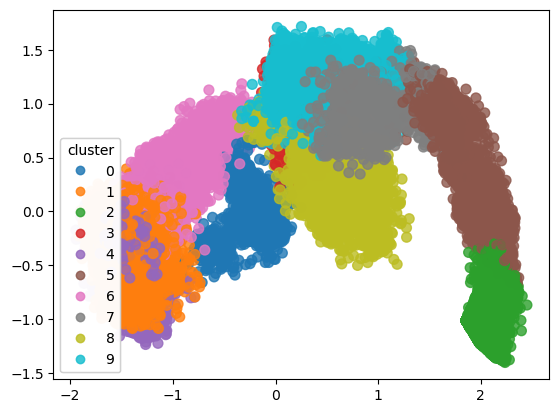

In [117]:
fig, ax = plt.subplots()
col = ax.scatter(X_transformed[:,0], X_transformed[:,1],  c=cluster_labels, s=50, alpha=0.8, cmap='tab10')
legend1 = ax.legend(*col.legend_elements(),loc="lower left", title="cluster")
ax.add_artist(legend1)


In [118]:
res_clusters = []
for cmap_df in cmap:
    contact_values = cmap_df.drop(['time'], axis=1).values
    x_embed = embedding.transform(contact_values)
    labels_embed = [f'pca_{dim}' for dim in range(x_embed.shape[1])]
    clusters = kmeans.predict(contact_values)
    res_df = pd.DataFrame(x_embed, columns=labels_embed)
    res_df['cluster_id'] = clusters
    res_df['time']=cmap_df['time']

    df1 = cmap_df.set_index(['time'])
    df2 = res_df.set_index(['time'])
    join1 = df1.join(df2)
    res_clusters.append(join1)


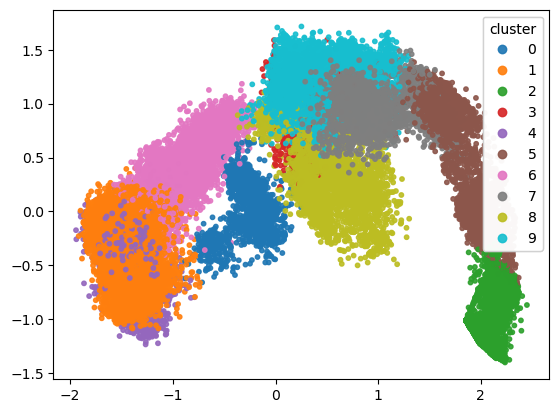

In [119]:
clus_concat = pd.concat(res_clusters)
fig, ax = plt.subplots()
col = ax.scatter(clus_concat['pca_0'], clus_concat['pca_1'],
                 c=clus_concat['cluster_id'], s=10, alpha=0.9, cmap='tab10')
legend1 = ax.legend(*col.legend_elements(), title="cluster")
ax.add_artist(legend1)



#### identify contacts in each cluster (not reweighed!)

In [120]:
contact_means_byclust = clus_concat.groupby('cluster_id').agg('mean').reset_index()
cmap_cols = [colname for colname in contact_means_byclust.columns if "cmap:" in colname]
fmap_cols = [colname for colname in contact_means_byclust.columns if "fmap:" in colname]

## calculate sum of contacts, this should be the same as the contact_count CV calculated before
contact_means_byclust['cmap_sum'] = contact_means_byclust[cmap_cols].sum(axis=1)
contact_means_byclust['fmap_sum'] = contact_means_byclust[fmap_cols].sum(axis=1)

formed_contacts = contact_means_byclust[cmap_cols+fmap_cols].max()>.5
contacts_bycluster = contact_means_byclust[formed_contacts.index[formed_contacts]]

In [121]:
contact_means_byclust[['cluster_id','pca_0','pca_1','cmap_sum','fmap_sum']]

,cluster_id,pca_0,pca_1,cmap_sum,fmap_sum
0,0,-0.279172,0.078436,14.186753,0.089790
1,1,-1.457678,-0.345497,17.584599,0.028981
2,2,2.033226,-1.078225,1.398086,1.208185
3,3,0.269230,1.001289,13.027234,0.009601
4,4,-1.445774,-0.419845,18.639591,0.005860
5,5,1.863404,0.358680,7.559483,1.589788
6,6,-0.899198,0.405934,16.373993,0.050903
7,7,1.173349,0.945398,10.959020,0.046584
8,8,0.545357,0.298411,10.718248,0.044962
9,9,0.462169,1.250224,12.437460,0.069489


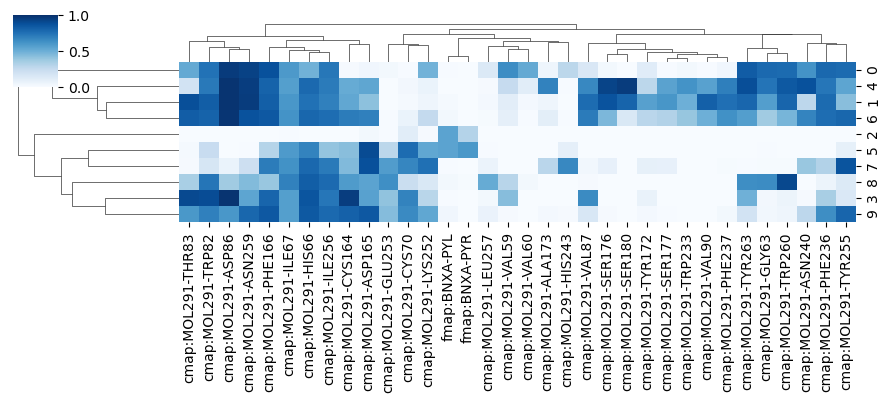

In [122]:
from seaborn import clustermap
g=clustermap(contacts_bycluster, figsize=(9,4), cmap="Blues", vmin=0, vmax=1)
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)

## Reweigh

### Join dataframes with old CVs, new CVs, and reweigh factors

In [123]:
## check that for all walkers the old and new dataframes have the same number of rows
for i in range(len(walkers_indices)):
  print((i, len(original_cvs_strided[i]), len(recalc_cvs[i]), len(contacts[i]), len(res_clusters[i])))


(0, 2001, 2001, 2001, 2001)
(1, 2001, 2001, 2001, 2001)
(2, 2001, 2001, 2001, 2001)
(3, 2001, 2001, 2001, 2001)
(4, 2001, 2001, 2001, 2001)
(5, 2001, 2001, 2001, 2001)
(6, 2001, 2001, 2001, 2001)
(7, 2001, 2001, 2001, 2001)
(8, 2001, 2001, 2001, 2001)
(9, 2001, 2001, 2001, 2001)
(10, 2001, 2001, 2001, 2001)
(11, 2001, 2001, 2001, 2001)
(12, 2001, 2001, 2001, 2001)
(13, 2001, 2001, 2001, 2001)
(14, 2001, 2001, 2001, 2001)
(15, 2001, 2001, 2001, 2001)
(16, 2001, 2001, 2001, 2001)
(17, 2001, 2001, 2001, 2001)
(18, 2001, 2001, 2001, 2001)
(19, 2001, 2001, 2001, 2001)
(20, 2001, 2001, 2001, 2001)
(21, 2001, 2001, 2001, 2001)
(22, 2001, 2001, 2001, 2001)
(23, 2001, 2001, 2001, 2001)
(24, 2001, 2001, 2001, 2001)
(25, 2001, 2001, 2001, 2001)
(26, 2001, 2001, 2001, 2001)
(27, 2001, 2001, 2001, 2001)
(28, 2001, 2001, 2001, 2001)
(29, 2001, 2001, 2001, 2001)
(30, 2001, 2001, 2001, 2001)
(31, 2001, 2001, 2001, 2001)


In [124]:

## join original cvs (which also contains the reweigh factor), the recalculated cvs, and the new cvs

joined_cvs = []

for i in range(len(walkers_indices)):

  original_setindex = original_cvs_strided[i].set_index(['time'])
  recalc_setindex = recalc_cvs[i].set_index(['time'])
  newcvs_setindex = contacts[i].set_index(['time'])
  res_clusters_setindex = res_clusters[i]

  res_clusters_setindex['delta_pca_0'] = np.append(res_clusters[i]['pca_0'][1:].values -res_clusters[i]['pca_0'][:-1].values,np.nan)
  res_clusters_setindex['delta_pca_1'] = np.append(res_clusters[i]['pca_1'][1:].values -res_clusters[i]['pca_1'][:-1].values,np.nan)

  join1 = original_setindex.join(recalc_setindex , rsuffix='recalc')
  join2 = join1.join(newcvs_setindex)
  join3 = join2.join(res_clusters_setindex)

  join3['walker_index'] = walkers_indices[i]

  joined_cvs.append(join3)

### calculate weights

In [125]:
## first concatenate all walters into a single dataframe

joined_cvs_concat = pd.concat(joined_cvs)
joined_cvs_concat.head()

joined_cvs_concat.to_csv(r'/sc/arion/projects/H_filizm02a/eduard_neu/Photoswitches/b2AR_3PDS_UW58_Z_cysteine/metaD_multiple_walker_30_ns_30_bias_firtz_new_mdp_gromacs_2022_5_C10_rep_restr_1/clustering_3_fragments/joined_cvs_contact.csv')

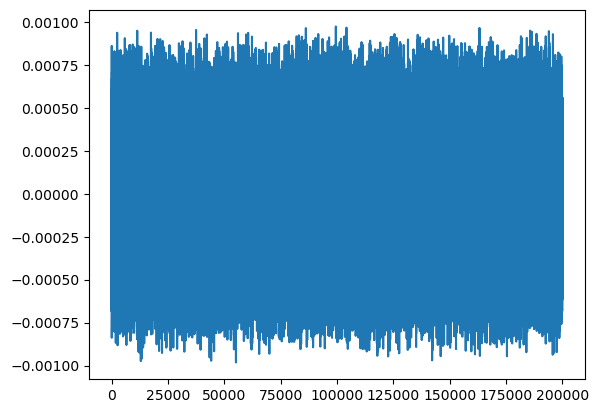

In [126]:
plt.plot(joined_cvs_concat['d1.z']-joined_cvs_concat['d1.zrecalc'])

In [127]:
## calculate weights from rbias
weight_nonnorm = np.exp(joined_cvs_concat['meta.rbias'].values)
joined_cvs_concat['weight'] = weight_nonnorm/np.sum(weight_nonnorm)

#### cluster population by trajectory

In [128]:
cluster_weights_trj = joined_cvs_concat.groupby(['walker_index','cluster_id']).agg({'weight':'count'}).reset_index()
cluster_weights_trj.pivot(index='walker_index',columns='cluster_id',values='weight')

cluster_id,0,1,2,3,4,5,6,7,8,9
walker_index,,,,,,,,,,
0,NaN,NaN,NaN,NaN,2001.0,NaN,NaN,NaN,NaN,NaN
1,NaN,2.0,NaN,NaN,1997.0,NaN,2.0,NaN,NaN,NaN
2,NaN,45.0,NaN,NaN,1956.0,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,2000.0,NaN,NaN,NaN,NaN,NaN
4,NaN,10.0,NaN,NaN,4.0,NaN,1986.0,NaN,NaN,1.0
5,NaN,NaN,NaN,NaN,NaN,NaN,2001.0,NaN,NaN,NaN
6,NaN,1996.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
7,NaN,1968.0,NaN,NaN,7.0,NaN,26.0,NaN,NaN,NaN
8,1884.0,115.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


In [129]:
cluster_weights = joined_cvs_concat.groupby(['cluster_id']).agg({'weight':'sum'}).reset_index()
#cluster_weights.pivot(index='walker_index',columns='cluster_id',values='weight')
cluster_weights['fes'] = -np.log(cluster_weights['weight'])
cluster_weights

,cluster_id,weight,fes
0,0,2.358712e-10,22.167735
1,1,7.549200e-01,0.281143
2,2,5.970478e-06,12.028683
3,3,2.388657e-06,12.944779
4,4,2.122531e-01,1.549976
5,5,3.582287e-06,12.539509
6,6,3.280539e-02,3.417162
7,7,4.547934e-09,19.208593
8,8,2.255391e-09,19.909943
9,9,9.553645e-06,11.558588


### plot as a function of old cv d1z

In [130]:
## do histogram on old cvs
joined_cvs_concat['bins_d1z'] = round(joined_cvs_concat['d1.z'],2)
fes1=joined_cvs_concat.groupby('bins_d1z').agg({'weight':'sum'}).reset_index()
fes1['fes'] = -np.log(fes1['weight'])

Text(0, 0.5, 'fes (kT)')

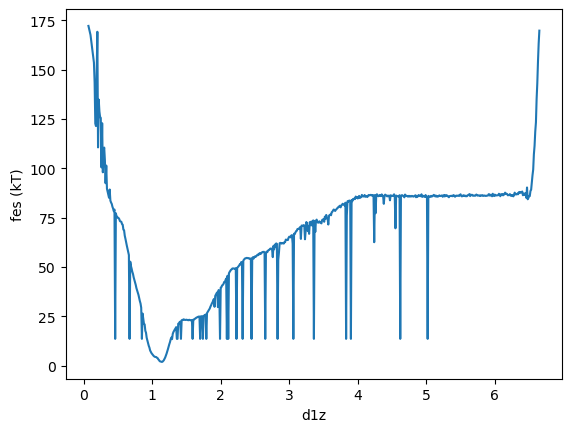

In [131]:
plt.plot(fes1['bins_d1z'],fes1['fes'])
plt.xlabel('d1z')
plt.ylabel('fes (kT)')

### plot as a function of contact map

In [132]:
## do histogram on new cvs
joined_cvs_concat['bins_contacts'] = round(joined_cvs_concat['contact_count'],0)
fes2=joined_cvs_concat.groupby('bins_contacts').agg({'weight':'sum'}).reset_index()
fes2['fes'] = -np.log(fes2['weight'])

Text(0, 0.5, 'fes (kT)')

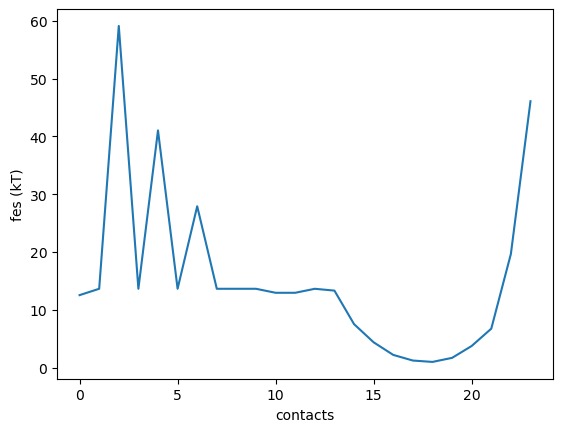

In [133]:
plt.plot(fes2['bins_contacts'],fes2['fes'])
plt.xlabel('contacts')
plt.ylabel('fes (kT)')

### plot 2d free-energy

In [134]:
## do histogram on new cvs
joined_cvs_concat['bins_contacts'] = round(joined_cvs_concat['contact_count'],0)
fes3=joined_cvs_concat.groupby(['bins_d1z','bins_contacts']).agg({'weight':'sum'}).reset_index()
fes3['fes'] = -np.log(fes3['weight'])


In [141]:
# double check that integrating one dimension we get the correct result
#fes3c = fes3.groupby(['bins_contacts']).agg({'weight':'sum'}).reset_index()
#fes3c['fes'] = -np.log(fes3c['weight'])
#plt.plot(fes3c['bins_contacts'],fes3c['fes'])
#plt.xlabel('contacts')
#plt.ylabel('fes (kT)')

Text(0, 0.5, 'contacts')

<Figure size 700x200 with 0 Axes>

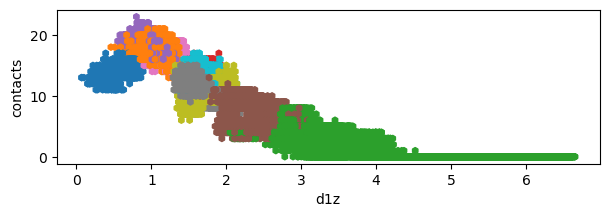

In [135]:
plt.figure(figsize=(7,2))
fig, ax = plt.subplots(figsize=(7,2))
im = plt.scatter(joined_cvs_concat['bins_d1z'],
                 joined_cvs_concat['bins_contacts'], marker="h", s=20,
                 c=joined_cvs_concat['cluster_id'], cmap='tab10')

legend1 = ax.legend(*im.legend_elements(), title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left', bbox_transform=plt.gcf().transFigure)
ax.add_artist(legend1)

plt.xlabel('d1z')
plt.ylabel('contacts')


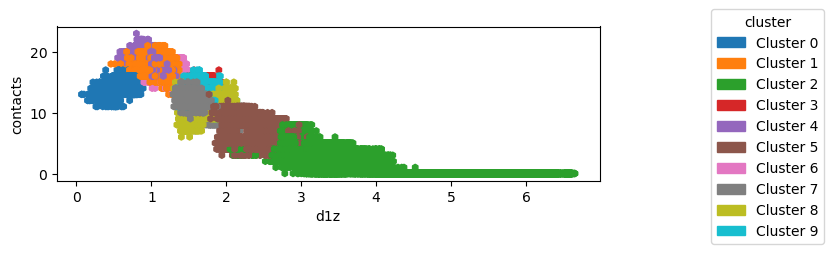

In [136]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7,2))
im = ax.scatter(joined_cvs_concat['bins_d1z'],
                joined_cvs_concat['bins_contacts'], marker="h", s=20,
                c=joined_cvs_concat['cluster_id'], cmap='tab10')

# Create custom legend
handles = [mpatches.Patch(color=plt.cm.tab10(i), label=f'Cluster {i}') for i in range(10)]
ax.legend(handles=handles, title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left', bbox_transform=plt.gcf().transFigure)

plt.xlabel('d1z')
plt.ylabel('contacts')

plt.show()


Text(0, 0.5, 'contacts')

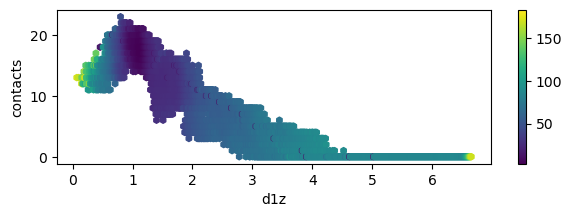

In [137]:
plt.figure(figsize=(7,2))
im = plt.scatter(fes3['bins_d1z'],fes3['bins_contacts'], marker="h", s=20, c=fes3['fes'], cmap=None)
plt.colorbar(im)
plt.xlabel('d1z')
plt.ylabel('contacts')

In [138]:
## do histogram on new cvs
joined_cvs_concat['bins_pca_0'] = round(joined_cvs_concat['pca_0'],2)
joined_cvs_concat['bins_pca_1'] = round(joined_cvs_concat['pca_1'],2)

fes4=joined_cvs_concat.groupby(['bins_pca_0','bins_pca_1']).agg({'weight':'sum'}).reset_index()
fes4['fes'] = -np.log(fes4['weight'])


Text(0, 0.5, 'bins_pca_1')

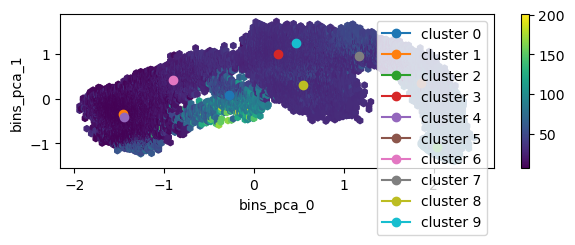

In [139]:
plt.figure(figsize=(7,2))
im = plt.scatter(fes4['bins_pca_0'],fes4['bins_pca_1'], marker="h", s=20, c=fes4['fes'], cmap=None)
plt.colorbar(im)

clcenters = contact_means_byclust[['cluster_id','pca_0','pca_1']]

for clI in clcenters['cluster_id']:
    plt.plot(clcenters[clcenters['cluster_id']==clI]['pca_0'],
             clcenters[clcenters['cluster_id']==clI]['pca_1'],
             marker='o', label=f'cluster {clI}')
    

# Move the legend outside the box
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.legend()
plt.xlabel('bins_pca_0')
plt.ylabel('bins_pca_1')

Text(0, 0.5, 'bins_pca_1')

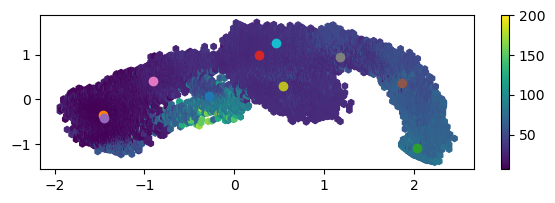

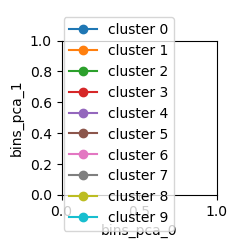

In [140]:
plt.figure(figsize=(7,2))
im = plt.scatter(fes4['bins_pca_0'],fes4['bins_pca_1'], marker="h", s=20, c=fes4['fes'], cmap=None)
plt.colorbar(im)

clcenters = contact_means_byclust[['cluster_id','pca_0','pca_1']]

for clI in clcenters['cluster_id']:
    plt.plot(clcenters[clcenters['cluster_id']==clI]['pca_0'],
             clcenters[clcenters['cluster_id']==clI]['pca_1'],
             marker='o', label=f'cluster {clI}')

# Create a separate legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
fig_legend.legend(handles, labels, loc='center')
fig_legend.canvas.draw()

plt.xlabel('bins_pca_0')
plt.ylabel('bins_pca_1')


#### Save trajs

In [141]:
frames_per_walker = 10
basedir = '/sc/arion/projects/H_filizm02a/eduard_neu/Photoswitches/b2AR_3PDS_UW58_Z_cysteine/metaD_multiple_walker_30_ns_30_bias_firtz_new_mdp_gromacs_2022_5_C10_rep_restr_1/clustering_3_fragments/'
clusterIDs = np.unique(clus_concat['cluster_id'])
for clID in clusterIDs:
  print(f'\nExtracting frames for cluster {clID}')
  cluster_traj_extracted = []
  for trj_index, trj in enumerate(trajectories):
    #print((clID, trj_index))
    cdata = res_clusters[trj_index]
    cdata_nrows = len(cdata)
    nframes = trj.n_frames
    frames_cluster = np.where(cdata['cluster_id']==clID)[0]
    print(f'clID={clID}, trj={trj_index} nframes={nframes}, cdata_nrows={cdata_nrows}, frames={len(frames_cluster)}')
    if len(frames_cluster)>0:
      ## randomise frames_per_walker
      frames_per_walker_safe = np.min([len(frames_cluster), frames_per_walker])
      keep_frames_cluster = np.random.choice(frames_cluster, frames_per_walker_safe, replace=False)
      cluster_traj_extracted.append(trj[keep_frames_cluster])
  res_trj = md.join(cluster_traj_extracted)
  filename = f'{basedir}/cluster_cl_{clID}.dcd'
  res_trj_whole = res_trj.image_molecules()
  res_trj_whole.save_dcd(filename)
  res_trj_whole[0].save_pdb(f'{basedir}/cluster_cl_{clID}.pdb')
  print(f'{res_trj.n_frames} frames saved in {filename}')




Extracting frames for cluster 0
clID=0, trj=0 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=1 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=2 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=3 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=4 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=5 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=6 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=7 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=8 nframes=2001, cdata_nrows=2001, frames=1884
clID=0, trj=9 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=10 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=11 nframes=2001, cdata_nrows=2001, frames=1
clID=0, trj=12 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=13 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=14 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=15 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=16 nframes=2001, cdata_nrows=2001, frames=0
clID=0, trj=17 nframes

In [142]:
# prepare microstates based on bins

def get_fes(cvs,cvs_names,prec):
   bin_vals = []
   fes = cvs.copy()
   for i, cv in enumerate(cvs_names):
      fes[f'bin_{cv}'] = round(cvs[cv]/prec,0)*prec
      ucv  = np.unique(fes[f'bin_{cv}'])
      print(f'cv_{i}->{cv} has {len(ucv)} values')
      bin_vals.append(ucv)

   print(f'number of microstates')
   bin_vals_mins = [min(bv/prec) for bv in bin_vals]
   bin_vals_len = [len(bv) for bv in bin_vals]
   for i, cv in enumerate(cvs_names):
      fes[f'binID_{cv}'] = (fes[f'bin_{cv}']/prec-bin_vals_mins[i]).astype(int)

   microst = []
   for index, row in fes.iterrows():
       microst.append( row['binID_pca_0']*bin_vals_len[1] + row['binID_pca_1'] )


   fes['micro_1d_FULL'] = np.array(microst).astype(int)
   fes['jump_n'] = np.append(np.array(microst)[1:] -np.array(microst)[:-1],np.nan)
   fes['jump'] = 1*(np.abs(fes['jump_n'])>0)

   tot_micro = np.prod([len(cvv) for cvv in bin_vals])
   pop_micro = len(np.unique(microst))
   print(f'{pop_micro} populated states out of {tot_micro}')
   micros = pd.DataFrame({'micro_1d_FULL':np.unique(microst).astype(int)})
   micros['micro_1d_SHORT'] = micros.index
   micros['id1'] = micros['micro_1d_FULL'] % bin_vals_len[1]
   micros['id0'] = ((micros['micro_1d_FULL'] - micros['id1'])/bin_vals_len[1]).astype(int)
   micros['val0'] = np.array(bin_vals[0])[micros['id0']]
   micros['val1'] = np.array(bin_vals[1])[micros['id1']]



   fes = fes.merge(micros, left_on='micro_1d_FULL', right_on= 'micro_1d_FULL', how='left')

   return fes,bin_vals,micros


#fes4=joined_cvs_concat.groupby(['bins_pca_0','bins_pca_1']).agg({'weight':'sum'}).reset_index()
#fes4['fes'] = -np.log(fes4['weight'])


fesX,bin_vals,micros = get_fes(joined_cvs_concat, ['pca_0','pca_1'],.2)

cv_0->pca_0 has 23 values
cv_1->pca_1 has 17 values
number of microstates
222 populated states out of 391


In [143]:
## get the cluster to which each bin belongs for (using the cluster most populates in each bin)
fesY = fesX.groupby(['micro_1d_FULL', 'micro_1d_SHORT','cluster_id']).size().reset_index()
idx = fesY.groupby(['micro_1d_FULL', 'micro_1d_SHORT'])[0].transform(max) == fesY[0]
bin2cluster = fesY[idx].groupby(['micro_1d_FULL', 'micro_1d_SHORT']).agg(min).reset_index()

/tmp/ipykernel_105551/4283794053.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = fesY.groupby(['micro_1d_FULL', 'micro_1d_SHORT'])[0].transform(max) == fesY[0]
/tmp/ipykernel_105551/4283794053.py:4: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  bin2cluster = fesY[idx].groupby(['micro_1d_FULL', 'micro_1d_SHORT']).agg(min).reset_index()


In [144]:
micro2clusters = [ bin2cluster[bin2cluster['cluster_id']==i]['micro_1d_SHORT'].values for i in np.unique(bin2cluster['cluster_id']) ]
micro2clusters

[array([ 51,  52,  59,  60,  61,  62,  69,  70,  71,  72,  73,  74,  79,
         80,  81,  82,  83,  84,  89,  90,  91,  92, 101]),
 array([ 3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23,
        24, 29, 30, 31, 32, 33, 40, 41, 49, 50]),
 array([179, 180, 181, 182, 191, 192, 193, 194, 195, 204, 205, 206, 207,
        208, 215, 216, 217, 218]),
 array([ 87,  88,  93,  94,  95,  96,  97, 105, 106, 107, 117, 118, 129]),
 array([ 0,  1,  2,  8, 17, 18, 27, 28, 37, 38, 39]),
 array([172, 173, 175, 176, 177, 178, 183, 184, 185, 186, 187, 188, 189,
        190, 196, 197, 198, 199, 200, 201, 202, 203, 209, 210, 211, 212,
        213, 214, 219, 220, 221]),
 array([16, 25, 26, 34, 35, 36, 42, 43, 44, 45, 46, 47, 48, 53, 54, 55, 56,
        57, 58, 63, 64, 65, 66, 67, 68, 75, 76, 77, 78]),
 array([128, 138, 139, 140, 149, 150, 151, 160, 161, 162, 163, 167, 168,
        169, 170, 171, 174]),
 array([ 85, 102, 103, 104, 112, 113, 114, 115, 116, 122, 123, 124, 125,
        126, 

In [145]:
if False:
  for f in fesX.columns:
    if not 'cmap'  in f and not 'fmap'  in f:
      print(f)

In [146]:
## calulate averages for constrains for MaxCal
deltaT = 0.01
rconts0 = deltaT*np.sum(np.abs(fesX['delta_pca_0'])*fesX['weight'])
rconts1 = deltaT*np.sum(np.abs(fesX['delta_pca_1'])*fesX['weight'])
jconts = deltaT*np.sum(np.abs(fesX['jump'])*fesX['weight'])
rconts = [rconts0, rconts1,jconts]
print(rconts)

[0.001180255070522025, 0.0013448628774282803, 0.00792077737759013]


In [147]:
# calculate stationary probabilities
fesX2=fesX.groupby(['micro_1d_FULL', 'micro_1d_SHORT', 'id1', 'id0']).agg({'weight':'sum'}).reset_index()
fesX2['q0'] = -np.log(fesX2['weight'])
fesX2['p0'] = fesX2['q0']/np.sum(fesX2['q0'])
p0 = fesX2['p0'].values

In [148]:
## Define matrices corresponing to the constraints for MaxCal

ndim = len(micros['val0'])
R0 = np.abs(np.add.outer(micros['val0'].values, - micros['val0'].values))
R1 = np.abs(np.add.outer(micros['val1'].values, - micros['val1'].values))
Jump = (1-np.diag([1]*ndim))
Adj = 1*np.logical_or(
    np.abs(np.add.outer(micros['id0'].values, - micros['id0'].values))<2,
    np.abs(np.add.outer(micros['id1'].values, - micros['id1'].values))<2)


In [149]:
def tmat_instant(pi0):
  return  np.repeat(pi0, repeats=len(pi0)). reshape((len(pi0),len(pi0))).transpose()

def get_probs(tmat):
  tmat2 = tmat.transpose()
  eigenvalues, eigenvectors = np.linalg.eig(tmat2)
  #print(eigenvalues)
  iperron = np.argmin(abs(eigenvalues-1))
  #print(iperron)
  tt = (eigenvectors)[:,iperron]
  #lambdas = sort(eigen(t(tmat))$values,decreasing = T)
  #lambda1 = lambdas[2]
  #assertthat::assert_that(sum(abs(Im(tt)))<1e-15)
  probs = tt.real/sum(tt.real)
  #names(probs) = colnames(tmat)
  #print(probs)
  return probs


def solveDD(A, pi0, xi=0.4, niter=200, keepiter=False, tol=1e-12):
  '''
  Solve the non-linear D(Ax)=x equation where
  D is the operator that mps a vector y into pi0/y (element-wise)
  '''
  ndim = A.shape[0]
  def DD(vec):
    return pi0/np.matmul(A,vec)

  vec = np.random.uniform(size=ndim)
  res= []
  for i in range(niter):
      if keepiter:
        res.append(vec)
      vec=(1-xi)*vec + xi*DD(vec)
      if all(np.abs(vec - DD(vec))<tol):
        break

  if not all(np.abs(vec - DD(vec))<tol):
       maxdelta = np.max(np.abs(vec - DD(vec)))
       print(f'convergence not achieved max={max}')

  return vec


def get_constraint(tmat, const_mat, prob=None):
  if prob==None:
     prob = get_probs(tmat)
  return np.sum(np.matmul(np.diag(prob), tmat*const_mat))

def lagDis(alpha, Dis, Adj, pi0, tol=1e-12, niter=200):
    Mat = Adj*np.exp(alpha*Dis)
    vec = solveDD(Mat,pi0,tol=tol,niter=niter)

    T2=np.outer(vec/pi0,vec)*Adj*np.exp(alpha*Dis)
    cval = get_constraint(T2,Dis)
    print(f'constraint value for this lagmult value is {cval}')
    return T2

def lagDis2(alphas, mats, Adj, pi0, tol=1e-12, niter=200, return_mat=False):
    assert len(alphas)==len(mats)
    tot = alphas[0]*mats[0]
    for i in range(1, len(mats)):
      tot = tot + alphas[i]*mats[i]

    vec = solveDD(Adj*np.exp(tot),pi0, tol=tol, niter=niter)
    T2=np.outer(vec/pi0,vec)*Adj*np.exp(tot)
    vals = [get_constraint(T2,mat) for mat in mats]
    print(f'values of constraints {vals}')
    if return_mat:
      return T2
    else:
      return vals


from scipy.optimize import fmin

def  tarDis2(targets, matlist, Adj, pis, lags0, abstol=0.1, maxit=20, verbose=True, return_matrix=False):
  assert len(targets)==len(matlist)

  def target_function(lags):
    restvals = lagDis2(lags, matlist, Adj, pis, return_mat=False)
    MUE = np.mean(np.abs(np.array(restvals) - np.array(targets)))
    if verbose:
      print(f'  optimization error: {MUE}')
    return MUE

  o1 = fmin(target_function,lags0, disp=False, full_output=True, retall=False)


  print(o1)
  Tmat3 = lagDis2(o1[0], matlist, Adj, pis, return_mat=True)

  if not return_matrix:
    print(f'param values: {o1[0]}')
    print(f'iterations: {o1[2]}')
    #check_tmat(Tmat3,pi0=pis, observables=myobs, tags=tags)
    return o1
  else:
    return Tmat3, o1[0]



### Transition path theory
def committor_plus(tmat, Aset, Bset, fill_end_states=True, verbose=False):
   Fset = np.arange(tmat.shape[0])
   Eset = np.append(np.array(Aset),np.array(Bset))
   Iset = np.setdiff1d(Fset,Eset)

   TI = tmat[Iset,:][:,Iset]
   II = np.diag([1]*len(Iset))
   if verbose:
     print(TI.shape)
     print(II.shape)

   A = TI - II
   vec = np.sum(tmat[Iset,:][:,Bset], axis=1)
   qi = linalg.solve(A, -vec)
   q = np.array([np.nan]*tmat.shape[0])

   if fill_end_states:
      q[Aset] = 0
      q[Bset] = 1
   q[Iset] = qi

   return q


def flux_AB(tmat,  Aset, Bset):
  qplus = committor_plus(tmat,  Aset, Bset)
  pi0 = get_probs(tmat)

  x1 = np.matmul( pi0[Aset].reshape((1, len(Aset))), tmat[Aset,:])
  x2 = np.matmul( x1, qplus.reshape((len(qplus),1)))

  return x2[0][0]


def rate_AB(tmat,  Aset, Bset, time_unit=1,verbose=False):
  qplus = committor_plus(tmat,  Aset, Bset)
  pi0 = get_probs(tmat)
  x1 = np.matmul( pi0[Aset].reshape((1, len(Aset))), tmat[Aset,:])
  x2 = np.matmul( x1, qplus.reshape((len(qplus),1)))
  Flux = x2[0][0]

  numm = sum(pi0*(1-qplus))
  if verbose:
    print(f('time unit {time_unit}'))
    print(f('setA size {len(Aset)}'))
    print(Aset)
    print(f('setB size {len(Bset)}'))
    print(Bset)
    print(f('rate: {Flux/(numm*time_unit)}'))

  return Flux/(numm*time_unit)

In [150]:
T4, lagrange_multipliers = tarDis2(rconts,[R0,R1,Jump], Adj, p0, [.1,.1,.1], return_matrix=True)

values of constraints [0.9094303078154433, 0.46477696509491523, 0.9823431179588901]
  optimization error: 0.7820348318479028
values of constraints [0.9137017754504352, 0.4637658189866027, 0.9824277469397847]
  optimization error: 0.7831498153504274
values of constraints [0.908418280335744, 0.46601525876966554, 0.982384959561861]
  optimization error: 0.78212420111391
values of constraints [0.9095148296830979, 0.46481872102282873, 0.9824285417713735]
  optimization error: 0.7821053990505865
values of constraints [0.9045436699844458, 0.4666423934734671, 0.9823435324312879]
  optimization error: 0.7810279001878868
values of constraints [0.8999691213209533, 0.4680827948405311, 0.9823016579061238]
  optimization error: 0.779969226247356
values of constraints [0.9041889369835704, 0.4657676103832444, 0.9823305469457374]
  optimization error: 0.7806137329956706
values of constraints [0.899546257995697, 0.4675982494638008, 0.9822212182376663]
  optimization error: 0.7796399434572079
values of c

In [151]:
## checks
print(np.mean(np.abs(get_probs(T4)-p0)))
print(np.sum(T4,axis=1))


print(lagDis2(lagrange_multipliers, [R0,R1,Jump], Adj, p0, return_mat=False))

5.687821582161941e-12
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
values of constraints [0.0011802532034261082, 0.0015597891982487325, 0.007920771035397295]
[0.0011802532034261082, 0.0015597891982487325, 0.007920771035397295]


In [152]:
from scipy import linalg
Tmat = linalg.expm(deltaT*(T4-np.diag([1]*ndim))*np.outer(p0,1/p0))

all( np.abs(Tmat.sum(axis=1)-1)<1e-3 )

True

In [153]:
print(micro2clusters)

[array([ 51,  52,  59,  60,  61,  62,  69,  70,  71,  72,  73,  74,  79,
        80,  81,  82,  83,  84,  89,  90,  91,  92, 101]), array([ 3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23,
       24, 29, 30, 31, 32, 33, 40, 41, 49, 50]), array([179, 180, 181, 182, 191, 192, 193, 194, 195, 204, 205, 206, 207,
       208, 215, 216, 217, 218]), array([ 87,  88,  93,  94,  95,  96,  97, 105, 106, 107, 117, 118, 129]), array([ 0,  1,  2,  8, 17, 18, 27, 28, 37, 38, 39]), array([172, 173, 175, 176, 177, 178, 183, 184, 185, 186, 187, 188, 189,
       190, 196, 197, 198, 199, 200, 201, 202, 203, 209, 210, 211, 212,
       213, 214, 219, 220, 221]), array([16, 25, 26, 34, 35, 36, 42, 43, 44, 45, 46, 47, 48, 53, 54, 55, 56,
       57, 58, 63, 64, 65, 66, 67, 68, 75, 76, 77, 78]), array([128, 138, 139, 140, 149, 150, 151, 160, 161, 162, 163, 167, 168,
       169, 170, 171, 174]), array([ 85, 102, 103, 104, 112, 113, 114, 115, 116, 122, 123, 124, 125,
       126, 127, 133, 134, 1

In [155]:
bound_states = np.concatenate([micro2clusters[i] for i in [1,4,6]])

In [156]:
out_states = np.concatenate([micro2clusters[i] for i in [2]])

In [157]:
rates2 = [
    {'from': 'bound', 'to': 'out' , 'mfpt': 0.04/ rate_AB(T4, bound_states, out_states)},
    {'from': 'out', 'to': 'bound' , 'mfpt':  0.04/rate_AB(T4,  out_states, bound_states,)}]

In [158]:
pd.DataFrame(rates2)

,from,to,mfpt
0,bound,out,1466.853837
1,out,bound,1272.070399
